## Gradient Boosting Machine

### Introduction
Gradient boosting gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees.When a decision tree is the weak learner, the resulting algorithm is called gradient-boosted trees, it usually outperforms random forest.We implement this algorithm mainly through the package **gbm**.

### Process
(1) Use the original data $d^0(x_i,y_i)$ to grow a shallow tree $\hat{r}^0(d^0)$. Save the prediction $f^0_i=\alpha\cdot\hat{r}^0(d^0,x_i)$, where $\alpha\in[0,1]$ is a shrinkage tuning parameter. Save the residual $e^0_i=y_i-f^0_i$, set $𝑚=1$.

(2) In the m-th iteration, use the data $d^m=(x_i,e^{m-1}_i)$ to grow a shallow tree $\hat{r}^m(d^m)$. Save the prediction $f^m_i=f^{m-1}+\alpha\cdot\hat{r}^m(d,x_i)$. Save the residual $e^m_i=y_i-f^m_i$. Update $𝑚=𝑚+1$.

(3) Repeat step (2) until $𝑚>𝑀$.

There are three tuning parameters: the tree depth, the hrinkage level $\alpha$, and the number of iterations $M$.The algorithm can be sensitive to any of the three tuning parameters.

In [1]:
load(url("https://github.com/zhentaoshi/Econ5821/raw/main/data_example/dataset_inf.Rdata"))

In [ ]:
library(ggplot2)
library(caret)

We first calculate the infaltion rate by CPI and PPI respectively, y is CPI or PPI
\begin{aligned}
inflation\_rate_t=logy_t-logy_{t-12}
\end{aligned}
This process is finished only by using the true data (i.e.the variable X), thus there is no inflation data for the first 12 months, that leaves 156 months of valid samples.

In [7]:
lncpi=log(cpi[13:168,2])-log(cpi[1:156,2])
lnppi=log(ppi[13:168,2])-log(ppi[1:156,2])
data=list()
for (i in 1:12){
  j=1
  data[[i]]=cbind(lnppi,X[12:167,-1])
  data[[i]]=cbind(lncpi,data[[i]])
  while (j<i){
    a=12-j
    b=167-j
    data[[i]]=cbind(data[[i]],X[a:b,-1])
    j=j+1
  }
}

### Model and cross-validation
We chose 12 models for predicting inflation, using the previous month's data to predict this month's inflation, the previous two months'data to predict this month's inflation, and so on, until we used the previous 12 months' data (i.e. the previous year) to predict this month's inflation rate.

In addition, we choose ten ways of cross validation. After calculating the inflation rate, the remaining effective samples are 168-12=156. Then, we scroll forward 10 training sets and test sets, that is, 1\~119 is the first training set, 120\~147 is the first test set, and so on, 10\~128 is the tenth training set. 129\~156 are the tenth test set.

We want to find the optimal combination of the 12 kinds of model and 10 kinds of CV way which maximize the out-of-sample R-squared, so we must carry on the $12\times10\times2=240$ gradient boosting (because we predict inflation rate by CPI and PPI respectively). This process is very time consuming, therefore, after testing the 240 groups of data, we directly saved the $OOSR^2$ of each group into csv format, and then imported it again. The test results are shown as follows

In [3]:
oosr2_cpi120 <- read.csv("oosr2_cpi120.csv")
oosr2_ppi120 <- read.csv("oosr2_ppi120.csv")

In [4]:
print(oosr2_cpi120)
print(oosr2_ppi120)

           X1         X2         X3         X4         X5         X6         X7
1  -2.1270952 -1.2645598 -1.4995397 -1.2668101 -0.8747479 -1.4328229 -1.5503644
2  -2.3154038 -1.4903361 -1.7096985 -1.5786795 -1.6738299 -1.1281805 -1.8695058
3  -3.0684543 -2.2195160 -2.1414251 -2.3413812 -2.3035555 -2.4125904 -2.9506426
4  -4.1376336 -2.5537516 -2.7002909 -2.5250023 -2.5182187 -2.3678646 -2.5301269
5  -3.8336805 -3.0200669 -3.0871249 -2.6072330 -2.8560092 -2.5116202 -2.7337069
6  -4.1075939 -3.0093585 -2.6219677 -2.7585321 -2.5439862 -2.5807481 -3.1238324
7  -2.4465449 -2.5565635 -1.8468409 -1.6290394 -1.5637518 -1.4402715 -1.7569179
8  -2.3455807 -2.0104842 -1.8003079 -1.3138605 -1.2679463 -1.0735196 -1.3142001
9  -2.8070677 -1.7416703 -1.4196684 -1.3394062 -1.3100710 -1.1164167 -1.0853617
10 -2.1976207 -1.9451709 -1.6226080 -1.1008767 -1.2507020 -0.9610143 -1.2229302
11 -2.1002124 -1.3769110 -1.5897562 -0.8319165 -0.9313446 -0.9234934 -1.2720540
12 -0.8252072 -0.4795412 -0.4728869 -0.5

We can see that the forecasts for inflation rate calculated by CPI are poor, while some combinations of forecasts for inflation rate by PPI  are OK, so we only forecast for inflation rate by PPI, and we're going to find the combination that makes the out-of-sample R squared the biggest.

In [14]:
t=10 #CV number
s=12 #model number

topnr2 <- function(x,n) {
  tempvec <- c(rep(0,120))
  for (i in 1:t) {
    tempvec[(12*i-11):(12*i)] <- as.vector(x[,i])
  }
  return(tail(sort(tempvec),n))
  rm(tempvec)
}

top1r2_ppi <- topnr2(oosr2_ppi120,1)
cat("The maximum of OOSR2 of forecast by PPI is",top1r2_ppi,"\n")
cat("The index of this result is [8,4]")

The maximum of OOSR2 of forecast by PPI is 0.7929955 
The index of this result is [8,4]

In [ ]:
install.packages("doParallel")
install.packages("gbm")
library(doParallel)
library(gbm)

### Result of the chosen optimal group
Finally, we choose to use the data of the previous 8 months to predict this month's PPI inflation rate, and then scroll forward 4 groups to make cross-validation.

In [ ]:
gbmGrid <- expand.grid(
  interaction.depth = seq(from = 10, to = 50, by = 30),
  n.trees = seq(from = 1000, to = 10000, by = 4000),
  shrinkage = c(0.01),
  n.minobsinnode = 20
)

formula_ppi.GBM <- lnppi ~ .

gbmControl=trainControl(method="repeatedcv",number=5,repeats=1)

In [19]:
backscale <- function(x,y) {
  mean <- y$mean[2]
  std <- y$std[2]
  for (i in 1:length(x)) {
    x[i] <- (x[i] * std) + mean
  }
  return(x)
}

In [20]:
spec.boosting <- function(j,i) {
  gbm_optimal <- list()
  e=i+118
  train_d <- data[[j]][i:e,]
  f=e+1
  g=i+146
  test_d <- data[[j]][f:g,]
  
  scal <- preProcess(train_d,method = c("center","scale"))
  
  train_data <- predict(scal,train_d)
  test_data <- predict(scal,test_d)
  
  c=151*j+2
  train_ppi = train_data[,c(2,4:c)]
  test_ppi = test_data[,c(2,4:c)]
  
  registerDoParallel(8)
  boostingReg_ppi=train(formula_ppi.GBM, 
                        data = train_ppi,
                        method="gbm",
                        distribution="gaussian",
                        trControl=gbmControl,
                        tuneGrid=gbmGrid,
                        metric="Rsquared",
                        verbose=F)
  doParallel::stopImplicitCluster()
  
  pred_lnppi.boosting <- predict(boostingReg_ppi,newdata=test_ppi)
  
  gbm_optimal$result <- data.frame(cbind(c(1:nrow(test_data)), test_d$lnppi, backscale(pred_lnppi.boosting,scal)))
  names(gbm_optimal$result) <- c("Month", "Inflation_rate", "Forecast")
  
  gbm_optimal$oors2 <- 1-var(test_data$lnppi-pred_lnppi.boosting)/var(test_data$lnppi)
  
  p = ggplot(data = gbm_optimal$result, aes(Month)) + 
    geom_line(aes(y = Forecast, color = "Forecast by PPI"), linetype = "dashed") +
    geom_line(aes(y = Inflation_rate, color = "Real")) +
    scale_color_manual('',
                       breaks=c('Forecast by PPI', 'Real'),
                       values=c('Forecast by PPI'='blue', 'Real'='red')) +
    labs(title="Forecast of inflation rate by PPI", x = "Month", y = "Inflation rate (by PPI)") +
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_y_continuous(labels=percent)
  
  gbm_optimal$graph <- p
  return(gbm_optimal)
}

In [ ]:
gbm_optimal <- spec.boosting(8,4)

In [47]:
cat("The best tuning parameters for GBM are: \n");
print(boostingReg_ppi$bestTune)

The best tuning parameters for GBM are: 
  n.trees interaction.depth shrinkage n.minobsinnode
3    9000                10      0.01             20


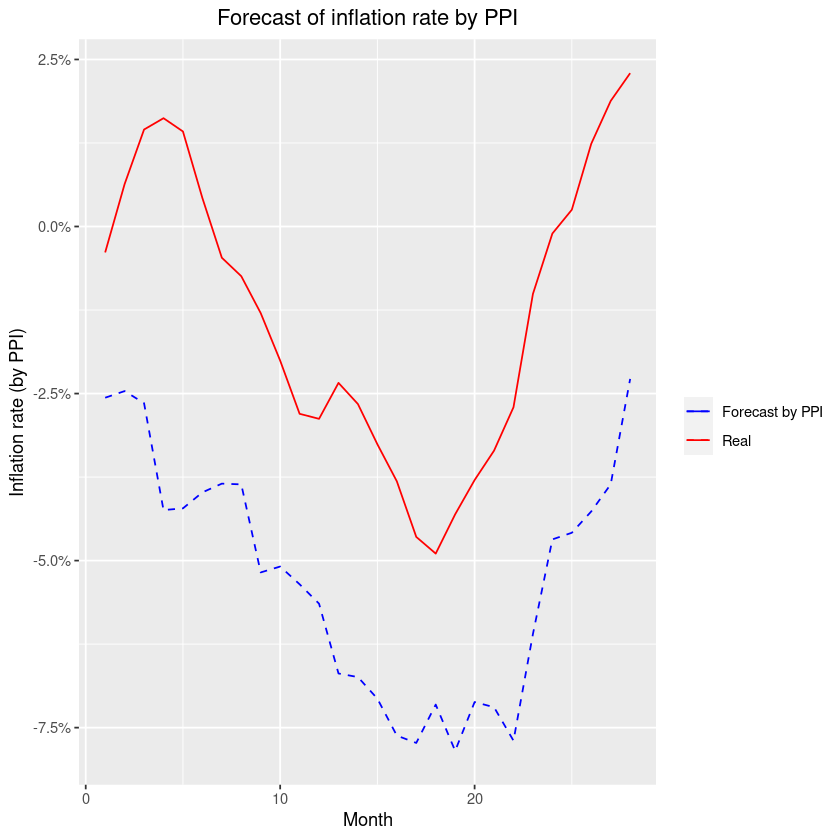

In [3]:
print(gbm_optimal$graph)

In [6]:
cat("The out-of-sample R-squared of [8,4] combination is",gbm_optimal$oors2)

The out-of-sample R-squared of [8,4] combination is 0.770423